# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from datetime import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.style.use('seaborn') #plt.style.available
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14

# Load Toronto Shelter Data

## Load files, concatenate, add date index to create DataFrame: **shelter_use**

In [3]:
# Load files from GitHub; add year labels
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Shelter%20Data/'
dso2017 = pd.read_csv(path + 'daily-shelter-occupancy-2017-csv.csv', 
                    parse_dates=['OCCUPANCY_DATE']); dso2017['source_file']=2017
dso2018 = pd.read_csv(path + 'daily-shelter-occupancy-2018-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2018['source_file']=2018
dso2019 = pd.read_csv(path + 'daily-shelter-occupancy-2019-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2019['source_file']=2019

# Get summary of records loaded
for year, df in [[2017,dso2017], [2018,dso2018], [2019,dso2019]]:
  print(f'Loaded {df.shape[0]} records and {df.shape[1]} columns from the {year} file.')

Loaded 38700 records and 14 columns from the 2017 file.
Loaded 37770 records and 14 columns from the 2018 file.
Loaded 39446 records and 14 columns from the 2019 file.


In [4]:
# Concatenate DataFrames
shelter_use = pd.concat([dso2017, dso2018, dso2019], ignore_index=True) 

# Get list of column names; change to Python standard lowercase:
cols = [column_name.lower() for column_name in shelter_use.columns] 
shelter_use.columns = cols

# Move source_file column to front of DataFrame
cols = cols[-1:] + cols[0:-1]
shelter_use = shelter_use[cols]

#Move occupancy_date column to index
shelter_use['Date']=shelter_use.occupancy_date
shelter_use.set_index('Date', inplace=True)

# Show sample records
print('Shape:',shelter_use.shape)
display(shelter_use.sample(5))

Shape: (115916, 14)


,source_file,_id,occupancy_date,organization_name,shelter_name,shelter_address,shelter_city,shelter_province,shelter_postal_code,facility_name,program_name,sector,occupancy,capacity
Date,,,,,,,,,,,,,,
2017-05-25,2017,15398,2017-05-25,Good Shepherd Ministries,Good Shepherd Centre,412 Queen Street East,Toronto,ON,M5A 1T3,Barrett House,Barrett House,Men,5,5.0
2018-03-18,2018,8074,2018-03-18,Homes First Society,HFS - Scarborough Shelter,3576 St. Clair Avenue East,Scarborough,ON,M1K 1M2,HFS - Scarborough Shelter,Homes First Society - Scarborough Shelter,Co-ed,88,90.0
2019-04-15,2019,11132,2019-04-15,City of Toronto,Scarborough Village Residence,3306 Kingston Road,Toronto,ON,M1M 1P8,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,22,48.0
2018-06-13,2018,17175,2018-06-13,City of Toronto,Women's Residence,674 Dundas St. W,Toronto,ON,M5T 1H9,Womens' Res - 63 Bellwoods Ave.,Womens' Residence - Bellwoods House,Women,9,10.0
2019-06-13,2019,17509,2019-06-13,City of Toronto,Birkdale Residence,1229 Ellesmere Road,Toronto,ON,M1P 4V8,Birkdale Residence Motel (Fam),Birkdale Residence - Toronto Plaza Hotel Progr...,Families,113,152.0


# Data Preparation

## Drop Nulls; Fix Data Types

- The shelter_postal_code column has 5494 missing values.
- The capacity column has 343 missing values.
  - 11 of those (null capacity) rows have occupancy values, which total 43 - all in 2017
  - All 343 rows were dropped.

In [5]:
# Identify columns with missing values:
for col in shelter_use.columns:
  null_count = shelter_use[col].isna().sum()
  if null_count >0:
    print(f'The {col} column has {null_count} rows without values.')

The shelter_postal_code column has 5494 rows without values.
The capacity column has 343 rows without values.


In [6]:
# Drop 343 rows with null capacity
original_row_count=shelter_use.shape[0]
shelter_use.dropna(subset=['capacity'], inplace=True)
dropped_row_count=original_row_count-shelter_use.shape[0]
print(f'Dropped {dropped_row_count} of {original_row_count} rows, due to nulls in capacity column.')

Dropped 343 of 115916 rows, due to nulls in capacity column.


In [7]:
# After removing nulls, change capacity column to integer
shelter_use.capacity = shelter_use.capacity.astype(int)

## Add New Columns (vacancy, vacancy_rate)

In [8]:
shelter_use['vacancy']=shelter_use.capacity - shelter_use.occupancy
#shelter_use['vacancy_rate']=shelter_use.vacancy/shelter_use.capacity*100

# EXPLORE FAMILY ISSUE!

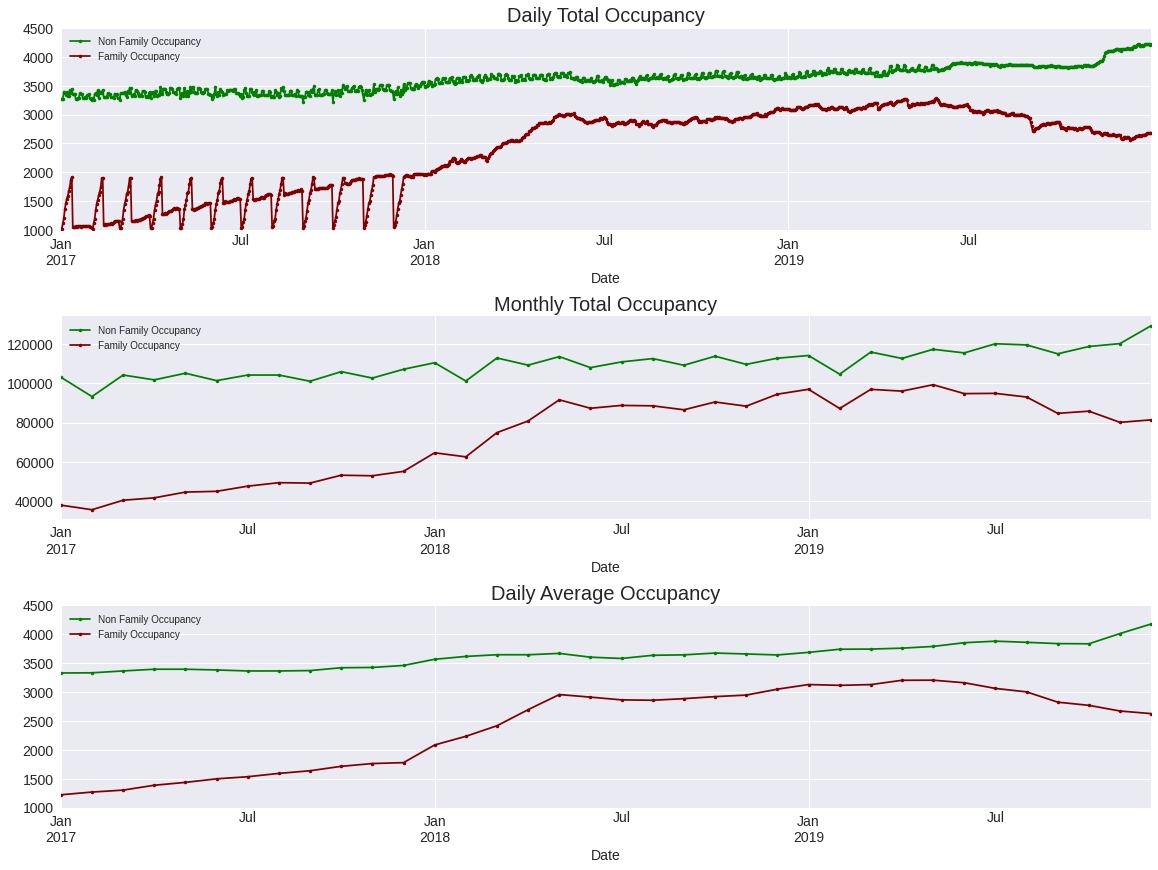

In [9]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)

df = shelter_use[shelter_use.sector!='Families']
df = df.resample('D')[['occupancy']].sum().rename(columns={'occupancy':'Non Family Occupancy'})
df.plot(marker='.', ax=ax1, ylim=(1000,4500), color='green');

df = shelter_use[shelter_use.sector=='Families']
df = df.resample('D')[['occupancy']].sum().rename(columns={'occupancy':'Family Occupancy'})
df.plot(title='Daily Total Occupancy', marker='.', ax=ax1, color='maroon')#, ylim=(1000,4500)); 
#---
df = shelter_use[shelter_use.sector!='Families']
df = df.resample('D')[['occupancy']].sum()
df = df.resample('M')[['occupancy']].sum().rename(columns={'occupancy':'Non Family Occupancy'})
df.plot(marker='.', ax=ax3, color='green')#, ylim=(1000,4500));

df = shelter_use[shelter_use.sector=='Families']
df = df.resample('D')[['occupancy']].sum()
df = df.resample('M')[['occupancy']].sum().rename(columns={'occupancy':'Family Occupancy'})
df.plot(title='Monthly Total Occupancy', marker='.', ax=ax3, color='maroon')#, ylim=(1000,4500)); 
#---
df = shelter_use[shelter_use.sector!='Families']
df = df.resample('D')[['occupancy']].sum()
df = df.resample('M')[['occupancy']].mean().rename(columns={'occupancy':'Non Family Occupancy'})
df.plot(marker='.', ax=ax5, ylim=(1000,4500), color='green');

df = shelter_use[shelter_use.sector=='Families']
df = df.resample('D')[['occupancy']].sum()
df = df.resample('M')[['occupancy']].mean().rename(columns={'occupancy':'Family Occupancy'})
df.plot(title='Daily Average Occupancy', marker='.', ax=ax5, color='maroon')#, ylim=(1000,4500)); 

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

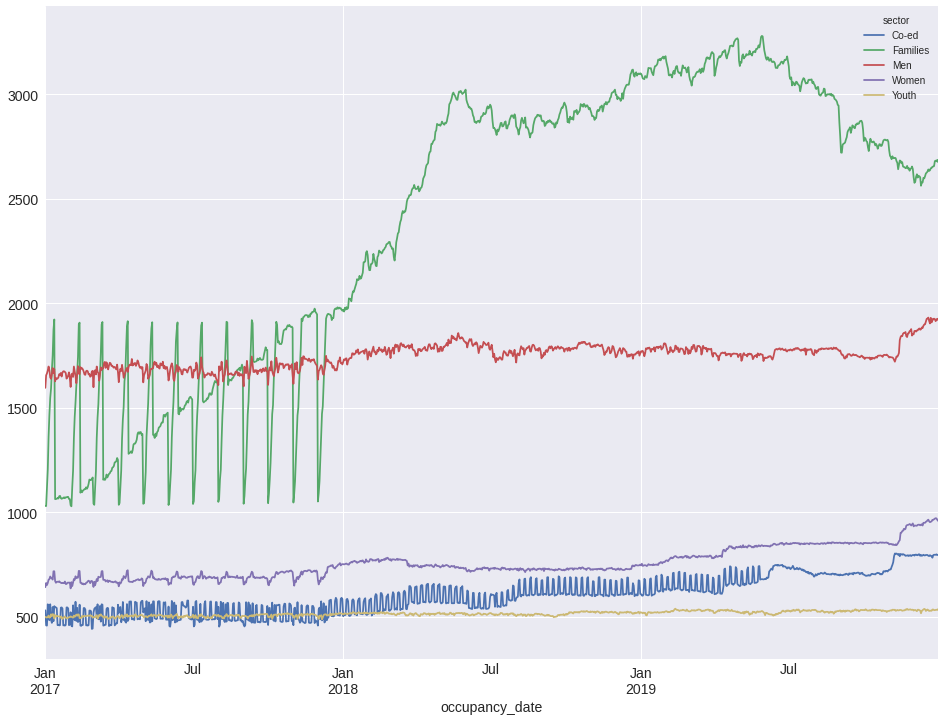

In [10]:
shelter_use.pivot_table(
    index=['occupancy_date'], 
    columns=['sector'],
    values='occupancy',
    aggfunc='sum').plot(figsize=(16, 12));plt.show();

# Export CSV Files for Further Analysis
Output Files:
- **shelter_use.csv**
  - original format with data prep
- **shelter_use_totals__daily.csv**
  - columns: capacity,	occupancy,	vacancy
  - one row per day (1095 rows)
- **shelter_use_totals_without_families__daily.csv**
  - data for 'Families' sector removed
- **shelter_use_totals_by_sector__daily.csv**
  - multi-level column index
  - one section of columns for capacity,	occupancy,	vacancy
    - one column (in each section) per sector

## Save File: **shelter_use.csv** 
## (original format with data prep)

In [11]:
#Save as csv:
filename_with_path = '/content/drive/My Drive/Colab Notebooks/3251 Statistics (UW)/FINAL GROUP PROJECT/Understanding-Toronto-Shelters/Shelter Data/shelter_use.csv'
shelter_use.to_csv(filename_with_path)

### Test csv: **shelter_use_totals__daily.csv**

In [12]:
#Test:
test = pd.read_csv(filename_with_path)
test.set_index(['Date']).head(3)

,source_file,_id,occupancy_date,organization_name,shelter_name,shelter_address,shelter_city,shelter_province,shelter_postal_code,facility_name,program_name,sector,occupancy,capacity,vacancy
Date,,,,,,,,,,,,,,,
2017-01-01,2017,1,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16,0
2017-01-01,2017,2,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17,4
2017-01-01,2017,3,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63,0


## Save File: **shelter_use_totals__daily.csv**
## (Pivot DataFrame to one row per day)

,capacity,occupancy,vacancy
Date,,,
2017-01-01,4653,4295,358
2017-01-02,4704,4299,405
2017-01-03,4733,4386,347
2017-01-04,4938,4600,338
2017-01-05,5011,4729,282


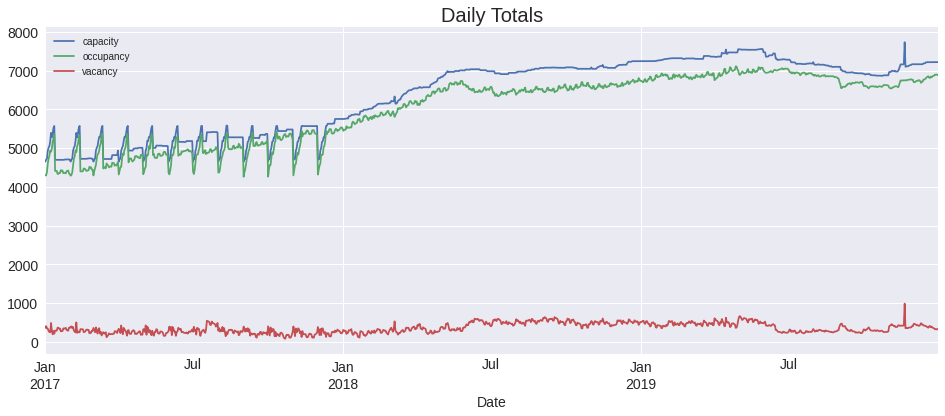

In [13]:
# Create monthly totals DataFrame:
shelter_use_totals_D = shelter_use.reset_index().pivot_table(values=['occupancy','capacity','vacancy'],aggfunc='sum',index='Date')
display(shelter_use_totals_D.head())
shelter_use_totals_D.plot(title='Daily Totals');

#Save as csv:
filename_with_path = '/content/drive/My Drive/Colab Notebooks/3251 Statistics (UW)/FINAL GROUP PROJECT/Understanding-Toronto-Shelters/Shelter Data/shelter_use_totals__daily.csv'
shelter_use_totals_D.to_csv(filename_with_path)

### Test csv: **shelter_use_totals__daily.csv**

In [14]:
#Test:
test = pd.read_csv(filename_with_path)
test

,Date,capacity,occupancy,vacancy
0,2017-01-01,4653,4295,358
1,2017-01-02,4704,4299,405
2,2017-01-03,4733,4386,347
3,2017-01-04,4938,4600,338
4,2017-01-05,5011,4729,282
...,...,...,...,...
1090,2019-12-27,7222,6899,323
1091,2019-12-28,7222,6895,327
1092,2019-12-29,7222,6904,318
1093,2019-12-30,7223,6896,327


## Save File: **shelter_use_totals_without_families__daily.csv**
##(Pivot to One Row Per Day; Remove Family Sector)

,capacity,occupancy,vacancy
Date,,,
2017-01-01,3503,3265,238
2017-01-02,3548,3270,278
2017-01-03,3577,3268,309
2017-01-04,3607,3396,211
2017-01-05,3629,3367,262


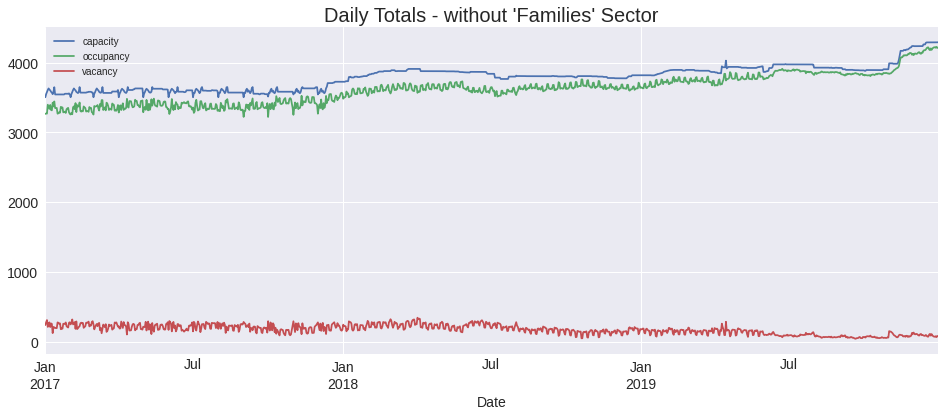

In [15]:
# Create monthly totals DataFrame:
shelter_use_totals_without_families_D = \
  shelter_use[shelter_use.sector!='Families'].reset_index().pivot_table(values=['occupancy','capacity','vacancy'],aggfunc='sum',index='Date')
display(shelter_use_totals_without_families_D.head())
shelter_use_totals_without_families_D.plot(title='Daily Totals - without \'Families\' Sector');

#Save as csv:
filename_with_path = '/content/drive/My Drive/Colab Notebooks/3251 Statistics (UW)/FINAL GROUP PROJECT/Understanding-Toronto-Shelters/Shelter Data/'+ \
  'shelter_use_totals_without_families__daily.csv'
shelter_use_totals_without_families_D.to_csv(filename_with_path)

## Save File: **shelter_use_totals_by_sector__daily.csv**
## (Pivot to one row *per sector* per day)

capacity                       ...  vacancy                 
sector        Co-ed Families   Men Women  ... Families  Men Women Youth
Date                                      ...                          
2017-01-01      582     1150  1706   697  ...      120  111    56    19
2017-01-02      582     1156  1751   697  ...      127   96    36    22
2017-01-03      582     1156  1780   697  ...       38  116    46    22
2017-01-04      612     1331  1792   685  ...      127  114    24    20
2017-01-05      622     1382  1792   697  ...       20   95    20    13

[5 rows x 15 columns]

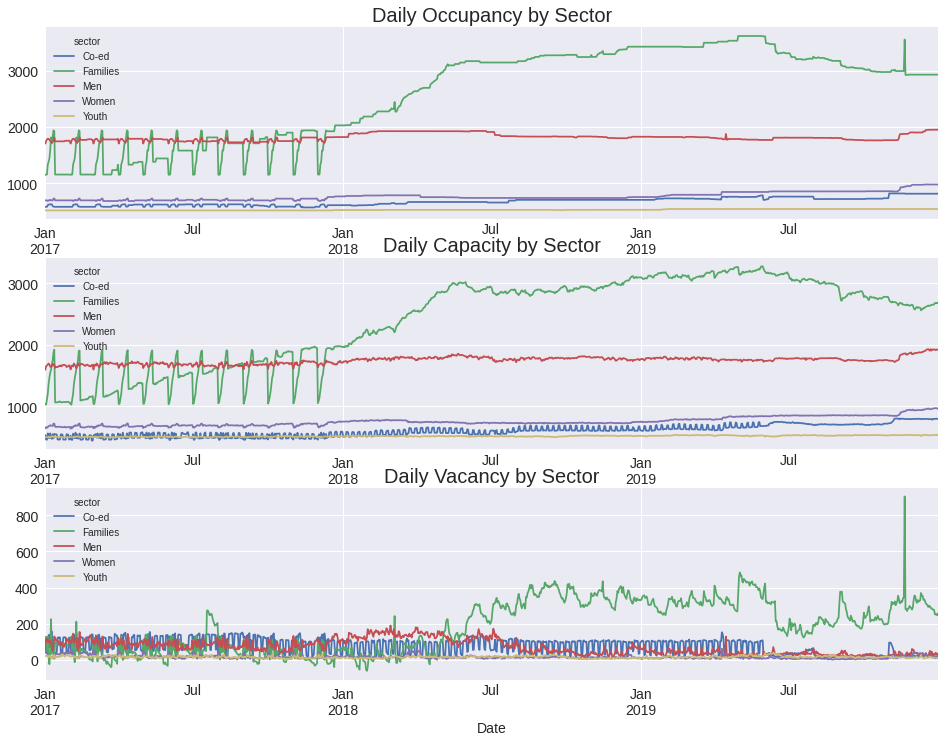

In [16]:
# Create monthly totals by sector DataFrame:
shelter_use_by_sector_D = shelter_use.reset_index().pivot_table(values=['occupancy','capacity','vacancy'],aggfunc='sum',columns='sector',index='Date')
display(shelter_use_by_sector_D.head())

fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((3, 1), (0, 0))
ax2 = plt.subplot2grid((3, 1), (1, 0))
ax3 = plt.subplot2grid((3, 1), (2, 0))
shelter_use_by_sector_D.capacity.plot(title='Daily Occupancy by Sector', ax=ax1);
shelter_use_by_sector_D.occupancy.plot(title='Daily Capacity by Sector', ax=ax2);
shelter_use_by_sector_D.vacancy.plot(title='Daily Vacancy by Sector', ax=ax3);

#Save:
filename_with_path = '/content/drive/My Drive/Colab Notebooks/3251 Statistics (UW)/FINAL GROUP PROJECT/Understanding-Toronto-Shelters/Shelter Data/shelter_use_totals_by_sector__daily.csv'
shelter_use_by_sector_D.to_csv(filename_with_path)

### Test csv: **shelter_use_totals_by_sector__daily.csv**

In [17]:
#Test:
test = pd.read_csv(filename_with_path, header=[0,1], index_col=0)
test

capacity                       ...  vacancy                 
sector        Co-ed Families   Men Women  ... Families  Men Women Youth
Date                                      ...                          
2017-01-01      582     1150  1706   697  ...      120  111    56    19
2017-01-02      582     1156  1751   697  ...      127   96    36    22
2017-01-03      582     1156  1780   697  ...       38  116    46    22
2017-01-04      612     1331  1792   685  ...      127  114    24    20
2017-01-05      622     1382  1792   697  ...       20   95    20    13
...             ...      ...   ...   ...  ...      ...  ...   ...   ...
2019-12-27      815     2932  1953   979  ...      252   30    10    12
2019-12-28      815     2932  1953   979  ...      250   39     8    11
2019-12-29      815     2932  1953   979  ...      253   29     9    10
2019-12-30      815     2932  1954   979  ...      246   34    16    11
2019-12-31      815     2932  1954   979  ...      257   28    21     7

[1095 rows x 15 columns]

### Sample Code for Dropping All 'Families' Columns

In [18]:
# Sample Code for Dropping All Family Columns:
test.drop('Families', axis=1, level=1)

capacity                   occupancy  ...       vacancy                 
sector        Co-ed   Men Women Youth     Co-ed  ... Youth   Co-ed  Men Women Youth
Date                                             ...                               
2017-01-01      582  1706   697   518       530  ...   499      52  111    56    19
2017-01-02      582  1751   697   518       458  ...   496     124   96    36    22
2017-01-03      582  1780   697   518       457  ...   496     125  116    46    22
2017-01-04      612  1792   685   518       559  ...   498      53  114    24    20
2017-01-05      622  1792   697   518       488  ...   505     134   95    20    13
...             ...   ...   ...   ...       ...  ...   ...     ...  ...   ...   ...
2019-12-27      815  1953   979   543       796  ...   531      19   30    10    12
2019-12-28      815  1953   979   543       796  ...   532      19   39     8    11
2019-12-29      815  1953   979   543       798  ...   533      17   29     9    10
2019-12-30      815  1954   979   543       795  ...   532      20   34    16    11
2019-12-31      815  1954   979   543       795  ...   536      20   28    21     7

[1095 rows x 12 columns]